In [1]:
import sys
sys.path.append('../src')

from module.module import Linear
from module.activation import TanH, Softmax, ReLU, Sigmoide

from loss.loss import CrossEntropie, CELogSoftmax
from networks.optim import Optim
from networks.sequentiel import Sequentiel

from utils.generation import generate_linear_data, generate_data_gauss
from utils.plots import plot_net, visualization, net_to_graph, classification_report

from utils.processing import one_hot_y, normalisation

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
body_perf_df = pd.read_csv('../data/bodyPerformance.csv')
print(body_perf_df.shape)
body_perf_df.head(2)

(13393, 12)


,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A


In [4]:
body_perf_df['gender'] = body_perf_df['gender'].replace({'M': 1, 'F': 0})
body_perf_df['class'] = body_perf_df['class'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3})
body_perf_df.head(2)

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,1,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,2
1,25.0,1,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,0


In [5]:
body_perf_df.describe()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
count,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000
mean,36.775106,0.632196,168.559807,67.447316,23.240165,78.796842,130.234817,36.963877,15.209268,39.771224,190.129627,1.500187
std,13.625639,0.482226,8.426583,11.949666,7.256844,10.742033,14.713954,10.624864,8.456677,14.276698,39.868000,1.118109
min,21.000000,0.000000,125.000000,26.300000,3.000000,0.000000,0.000000,0.000000,-25.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,162.400000,58.200000,18.000000,71.000000,120.000000,27.500000,10.900000,30.000000,162.000000,1.000000
50%,32.000000,1.000000,169.200000,67.400000,22.800000,79.000000,130.000000,37.900000,16.200000,41.000000,193.000000,2.000000
75%,48.000000,1.000000,174.800000,75.300000,28.000000,86.000000,141.000000,45.200000,20.700000,50.000000,221.000000,3.000000
max,64.000000,1.000000,193.800000,138.100000,78.400000,156.200000,201.000000,70.500000,213.000000,80.000000,303.000000,3.000000


In [6]:
y = body_perf_df['class'].values
X = body_perf_df.drop(['class'], axis=1).values

X = normalisation(X)

y.shape, X.shape

((13393,), (13393, 11))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [8]:
X_train.shape

(10044, 11)

100%|██████████| 300/300 [01:12<00:00,  4.14it/s]


Training completed.


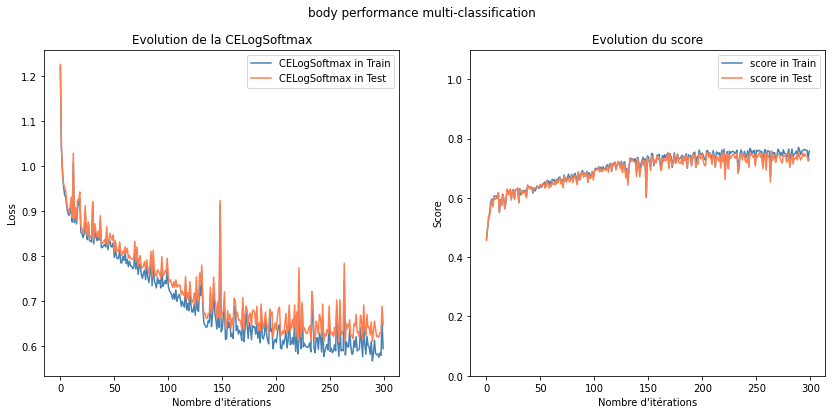

In [17]:
classes = len(np.unique(y))

input_neurons = X_train.shape[1]
output_neurons = classes

y_train_one_hot = one_hot_y(y_train, classes)

hidden_neurons_1 = 128
hidden_neurons_2 = 64
hidden_neurons_3 = 32

net = Sequentiel([
    Linear(input_neurons, hidden_neurons_1, bias=True, init="xavier"),
    TanH(),
    Linear(hidden_neurons_1, hidden_neurons_2, bias=True, init="xavier"),
    TanH(),
    Linear(hidden_neurons_2, hidden_neurons_3, bias=True, init="xavier"),
    TanH(),
    Linear(hidden_neurons_3, output_neurons, bias=True, init="xavier"),
], classes_type="multi")

optim = Optim(net, CELogSoftmax(), eps=1e-3)
optim.SGD(X_train, y_train_one_hot, test_train_split=True, batch_size=10, epochs=300, verbose=False)

plot_net(optim, X_train, y_train_one_hot, net_type="multiclass", net_title="body performance multi-classification")

In [21]:
net_to_graph(net, horizontal=True, net_name='sport_multiclass')

In [18]:
net.score(X_train, y_train)

0.7519912385503783

In [19]:
net.score(X_test, y_test)

0.7408181546730367

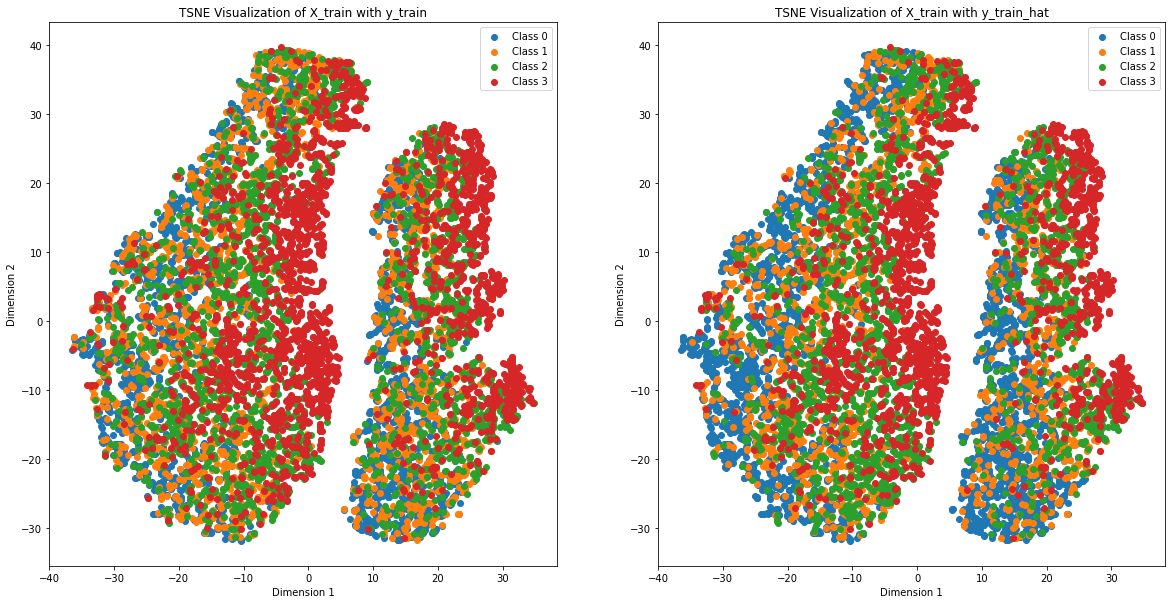

In [20]:
aff = TSNE(n_components=2, random_state=0, init="pca", n_iter=500, verbose=0)
sign_aff = aff.fit_transform(X_train)

colors = {i: plt.cm.tab10(i) for i in range(classes)}

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].set_title("TSNE Visualization of X_train with y_train")

for cl in range(classes):
    axs[0].scatter(sign_aff[y_train == cl][:, 0], sign_aff[y_train == cl][:, 1], color=colors[cl], label=f"Class {cl}")
    
axs[0].set_xlabel("Dimension 1")
axs[0].set_ylabel("Dimension 2")
axs[0].legend()

y_train_hat = net.predict(X_train).reshape(-1)


axs[1].set_title("TSNE Visualization of X_train with y_train_hat")
for cl in range(classes):
    axs[1].scatter(sign_aff[y_train_hat == cl][:, 0], sign_aff[y_train_hat == cl][:, 1], color=colors[cl], label=f"Class {cl}")
    
axs[1].set_xlabel("Dimension 1")
axs[1].set_ylabel("Dimension 2")
axs[1].legend()

plt.show()

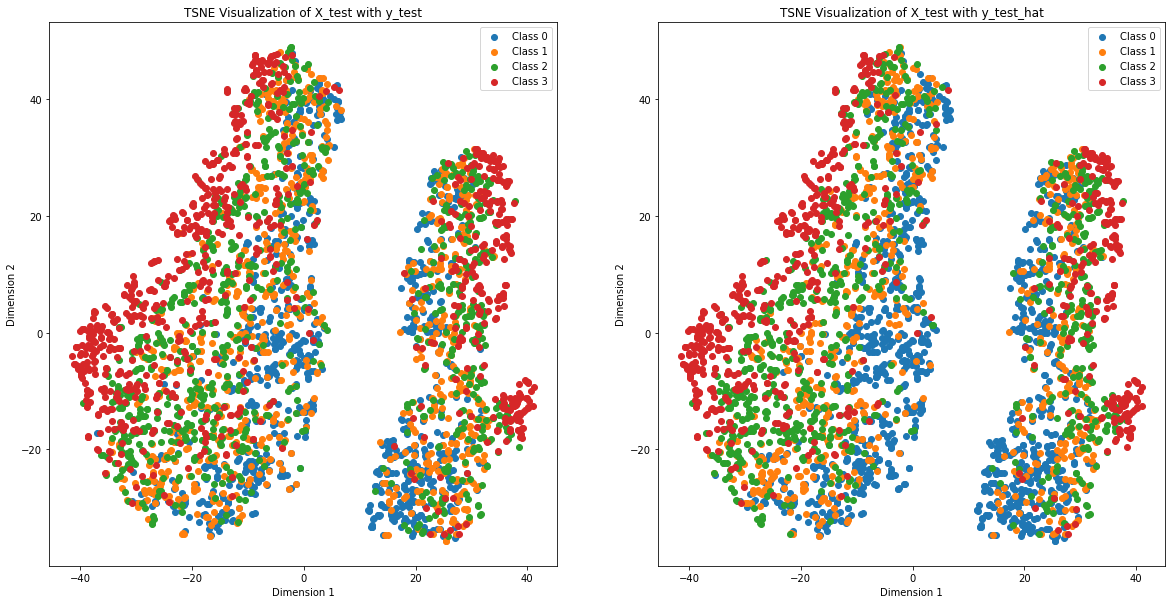

In [25]:
aff = TSNE(n_components=2, random_state=0, init="pca", n_iter=500, verbose=0)
sign_aff = aff.fit_transform(X_test)

colors = {i: plt.cm.tab10(i) for i in range(classes)}

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].set_title("TSNE Visualization of X_test with y_test")

for cl in range(classes):
    axs[0].scatter(sign_aff[y_test == cl][:, 0], sign_aff[y_test == cl][:, 1], color=colors[cl], label=f"Class {cl}")
    
axs[0].set_xlabel("Dimension 1")
axs[0].set_ylabel("Dimension 2")
axs[0].legend()

y_test_hat = net.predict(X_test).reshape(-1)

axs[1].set_title("TSNE Visualization of X_test with y_test_hat")
for cl in range(classes):
    axs[1].scatter(sign_aff[y_test_hat == cl][:, 0], sign_aff[y_test_hat == cl][:, 1], color=colors[cl], label=f"Class {cl}")
    
axs[1].set_xlabel("Dimension 1")
axs[1].set_ylabel("Dimension 2")
axs[1].legend()

plt.show()

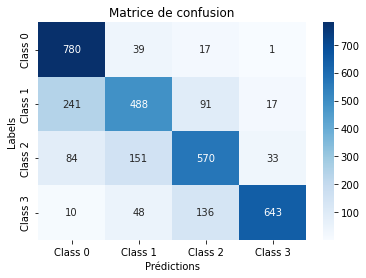

In [27]:
df = classification_report(y_test, y_test_hat, [f"Class {i}" for i in range(classes)])

In [28]:
print(df.to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrllr}
\toprule
{} &  precision & recall & f1-score &  support \\
class    &            &        &          &          \\
\midrule
Class 0  &       0.70 &   0.93 &     0.80 &      837 \\
Class 1  &       0.67 &   0.58 &     0.62 &      837 \\
Class 2  &       0.70 &   0.68 &     0.69 &      838 \\
Class 3  &       0.93 &   0.77 &     0.84 &      837 \\
accuracy &       0.74 &        &          &     3349 \\
\bottomrule
\end{tabular}



## Comparaison avec SVM : 

In [24]:
classifier = svm.SVC()

classifier.fit(X_train, y_train.reshape(-1))

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test.reshape(-1), y_pred.reshape(-1))
print("Précision du modèle :", accuracy)

Précision du modèle : 0.6431770677814272
